# Test web application locally


This notebook pulls some images and tests them against the local web app running inside the Docker container we made previously.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import numpy as np
from testing_utilities import to_img, img_url_to_json, plot_predictions 
import requests
from dotenv import get_key
%matplotlib inline

In [2]:
image_name = get_key('.env', 'docker_login') + '/' +get_key('.env', 'image_repo') 
image_name

'masalvar/pytorch-gpu'

Run the Docker conatainer in the background and open port 80. Notice we are using nvidia-docker and not docker command.

In [3]:
%%bash --bg -s "$image_name"
nvidia-docker run -p 80:80 $1

Wait a few seconds for the application to spin up and then check that everything works.

In [5]:
!curl 'http://0.0.0.0:80/'

Healthy

In [6]:
!curl 'http://0.0.0.0:80/version' #reports tensorflow version

0.4.1

Pull an image of a Lynx to test our local web app with.

In [7]:
IMAGEURL = "https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Lynx_lynx_poing.jpg/220px-Lynx_lynx_poing.jpg"

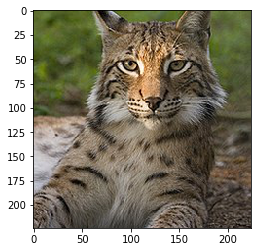

In [8]:
plt.imshow(to_img(IMAGEURL))

In [9]:
jsonimg = img_url_to_json(IMAGEURL)
jsonimg[:100] 

'{"input": {"image": "\\"iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAIAAACVT/22AAABJGlDQ1BJQ0MgUHJvZmlsZQAAeJxjY'

In [11]:
headers = {'content-type': 'application/json'}
%time r = requests.post('http://0.0.0.0:80/score', data=jsonimg, headers=headers)
print(r)
r.json()

CPU times: user 3.16 ms, sys: 0 ns, total: 3.16 ms
Wall time: 83.1 ms
<Response [200]>


{'result': [{'image': [['n02127052 lynx, catamount', 0.9965722560882568],
    ['n02128757 snow leopard, ounce, Panthera uncia', 0.0013256857637315989],
    ['n02128385 leopard, Panthera pardus', 0.0009192737634293735]]},
  'Computed in 77.41 ms']}

Let's try a few more images.

In [12]:
images = ('https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Lynx_lynx_poing.jpg/220px-Lynx_lynx_poing.jpg',
          'https://upload.wikimedia.org/wikipedia/commons/3/3a/Roadster_2.5_windmills_trimmed.jpg',
          'https://upload.wikimedia.org/wikipedia/commons/thumb/e/e6/Harmony_of_the_Seas_%28ship%2C_2016%29_001.jpg/1920px-Harmony_of_the_Seas_%28ship%2C_2016%29_001.jpg',
          'http://yourshot.nationalgeographic.com/u/ss/fQYSUbVfts-T7pS2VP2wnKyN8wxywmXtY0-FwsgxpiZv_E9ZfPsNV5B0ER8-bOdruvNfMD5EbP4SznWz4PYn/',
          'https://cdn.arstechnica.net/wp-content/uploads/2012/04/bohol_tarsier_wiki-4f88309-intro.jpg',
          'http://i.telegraph.co.uk/multimedia/archive/03233/BIRDS-ROBIN_3233998b.jpg')

In [13]:
url = 'http://0.0.0.0:80/score'
results = [requests.post(url, data=img_url_to_json(img), headers=headers) for img in images]

/anaconda/envs/AKSDeploymentPytorch/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


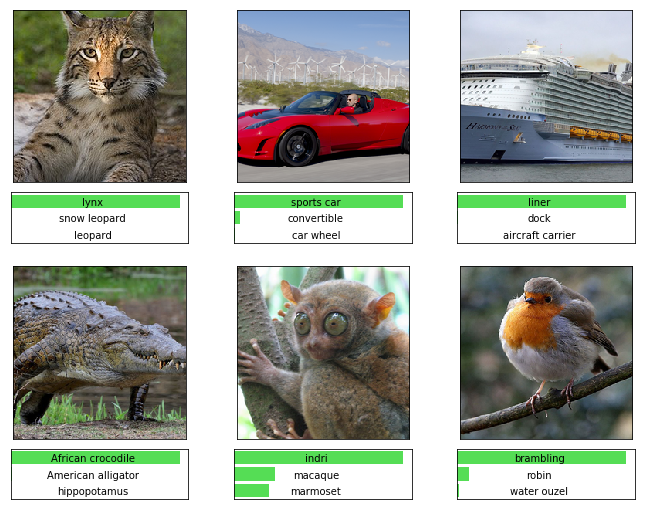

In [14]:
plot_predictions(images, results)

Next let's quickly check what the request response performance is for the locally running Docker container.

In [15]:
image_data = list(map(img_url_to_json, images)) # Retrieve the images and data

In [16]:
timer_results = list()
for img in image_data:
    res=%timeit -r 1 -o -q requests.post(url, data=img, headers=headers)
    timer_results.append(res.best)

In [17]:
timer_results

[0.05627424172125757,
 0.056118309311568734,
 0.055465328879654406,
 0.05571874286979437,
 0.0562732616905123,
 0.05612968946807086]

In [18]:
print('Average time taken: {0:4.2f} ms'.format(10**3 * np.mean(timer_results)))

Average time taken: 56.00 ms


In [19]:
%%bash
docker stop $(docker ps -q)

606dadd18f05


We can now [deploy our web application on AKS](04_DeployOnAKS.ipynb).